# Trained model visualisation and evaluation

In [1]:
import os
import sys
import wfdb
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('/workspaces/ECG-ML-Challenge/notebooks/', "..")))
from src.dataset.processing import aux2vec
from src import config
from src.visualization import plot_ecg

import numpy as np

Signal: ['MLII', 'V1']
Frequency: 360


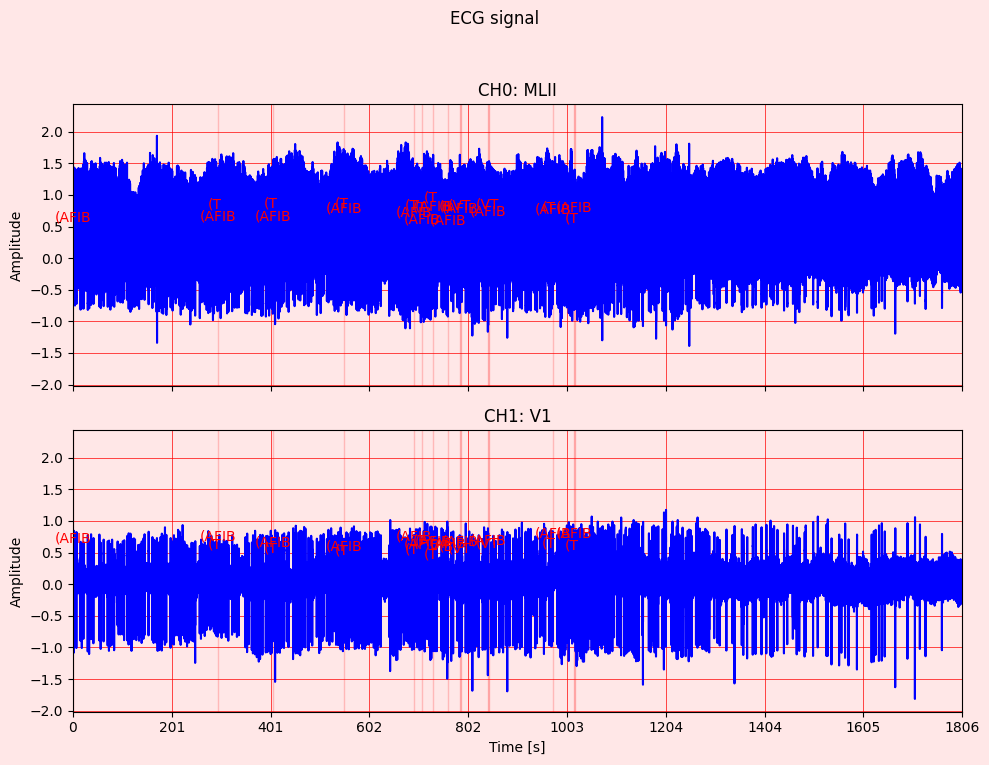

In [5]:
signal = '221'
t_start = 0
t_end = 1800

record = wfdb.rdrecord(os.path.join(config.RAW_DATA_DIR, 'mitdb', signal))
annotation = wfdb.rdann(os.path.join(config.RAW_DATA_DIR, 'mitdb', signal), 'atr')
print(f'Signal: {record.sig_name}')
print(f'Frequency: {record.fs}')
_ = plot_ecg(record, record.fs, annotation=annotation)

1928


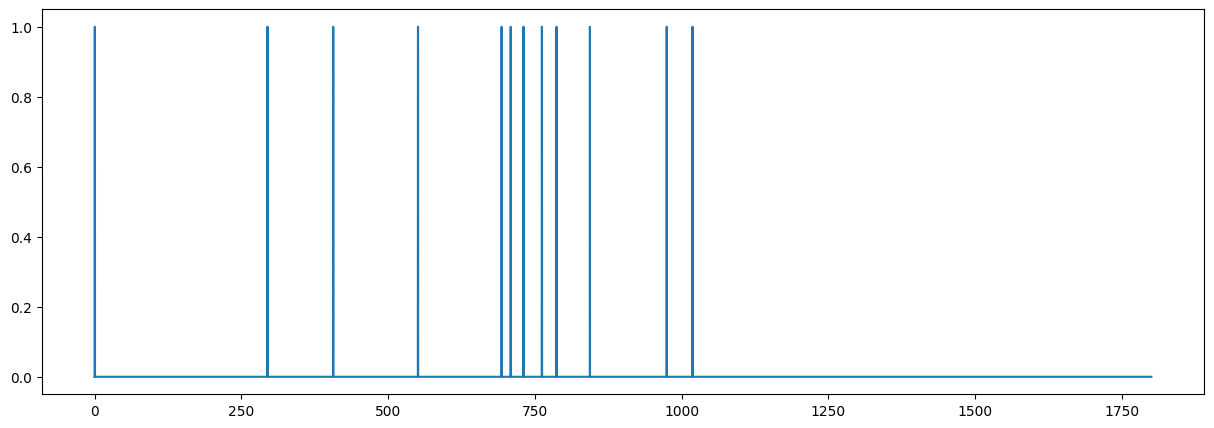

In [21]:
y = aux2vec(annotation, record.fs, record.sig_len)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(np.arange(t_start, t_end, 1/record.fs), y[t_start*record.fs:t_end*record.fs])
print(y.sum())

In [ ]:
import torch
from src.model import models

model_file = 'GPTMultiScaleConvGRUModel_20241122_2142_20_192_0.001.pth'
model = models.GPTMultiScaleConvGRUModel()

# Run to gówno jeżeli się pojawiają te gówna _orig_mod. w nazwach warstw (np. kiedy wczytujesz artefakt z wandb)
# state_dict = torch.load(os.path.join(config.MODELS_DIR, model_file), map_location=torch.device('cpu'), weights_only=True)
# new_state_dict = {}
# for k, v in state_dict.items():
#     new_state_dict[k.replace('_orig_mod.', '')] = v
# model.load_state_dict(new_state_dict, strict=False)

# Run to gówno w przeciwnym przypadku
model.load_state_dict(torch.load(os.path.join(config.MODELS_DIR, model_file), map_location=torch.device('cpu'), weights_only=True))
model.eval()

In [8]:
import wfdb.processing

TRAINED_CHUNK_SIZE = 2000
TRAINED_FS = 250

signals = []
for i in range(record.n_sig):
    signal, _ = wfdb.processing.resample_sig(record.p_signal.T[i, ...], record.fs, TRAINED_FS)
    signals.append(signal)
signal = np.array(signals)

ch, sig_len = signal.shape
print(f'Input signal shape: {signal.shape}')

if sig_len % TRAINED_CHUNK_SIZE != 0:
    padding = TRAINED_CHUNK_SIZE - (sig_len % TRAINED_CHUNK_SIZE)
    print(f"Applying padding of size {padding} to the data.")
    signal = np.pad(signal, ((0, 0), (0, padding)), "constant")
    print(f'Padded signal shape: {signal.shape}')

num_chunks = sig_len // TRAINED_CHUNK_SIZE
chunks = [signal[:, i * TRAINED_CHUNK_SIZE : (i + 1) * TRAINED_CHUNK_SIZE] for i in range(num_chunks)]
print(f'Number of chunks: {len(chunks)}')

Input signal shape: (2, 451388)
Applying padding of size 612 to the data.
Padded signal shape: (2, 452000)
Number of chunks: 225


In [54]:
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

torch.backends.nnpack.enabled = False

idx_start = t_start * TRAINED_FS
idx_end = t_end * TRAINED_FS

chunk_id = idx_start // TRAINED_CHUNK_SIZE + 1

Y = []
X = []
for chunk in chunks:
    with torch.no_grad():
        X.append(chunk)
        x = torch.tensor(normalize(chunk, axis=1), dtype=torch.float32)
        x = x.squeeze(0)
        y = model(x)
        y = torch.sigmoid(y).numpy()
    Y.append(y)

X = np.concatenate(X, axis=1)
Y = np.concatenate(Y, axis=1)

print(Y.shape)

(2, 450000)


[333057 337344]


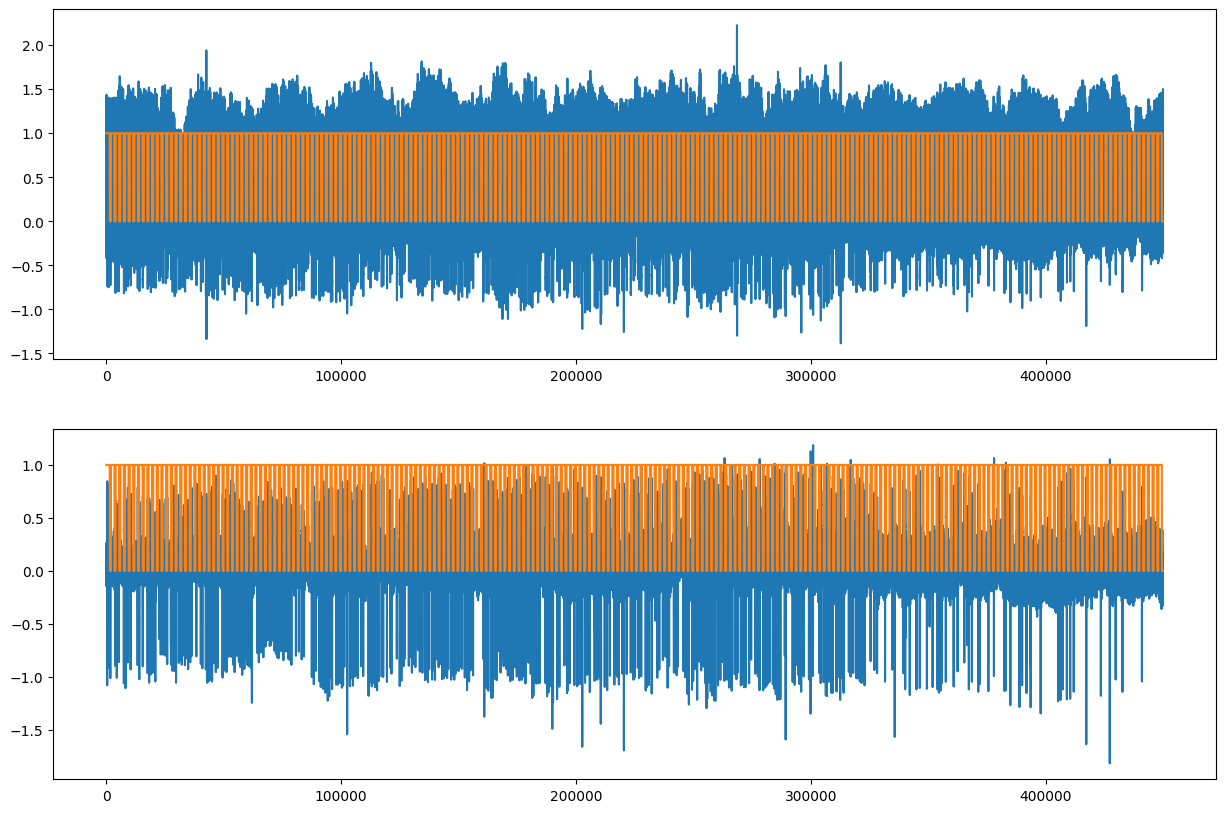

In [47]:
threshold = 1
print((Y >= threshold).sum(axis=1))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(X[0, ...])
ax1.plot(Y[0, ...]>=threshold)
ax2.plot(X[1, ...])
ax2.plot(Y[1, ...]>=threshold)
plt.show()

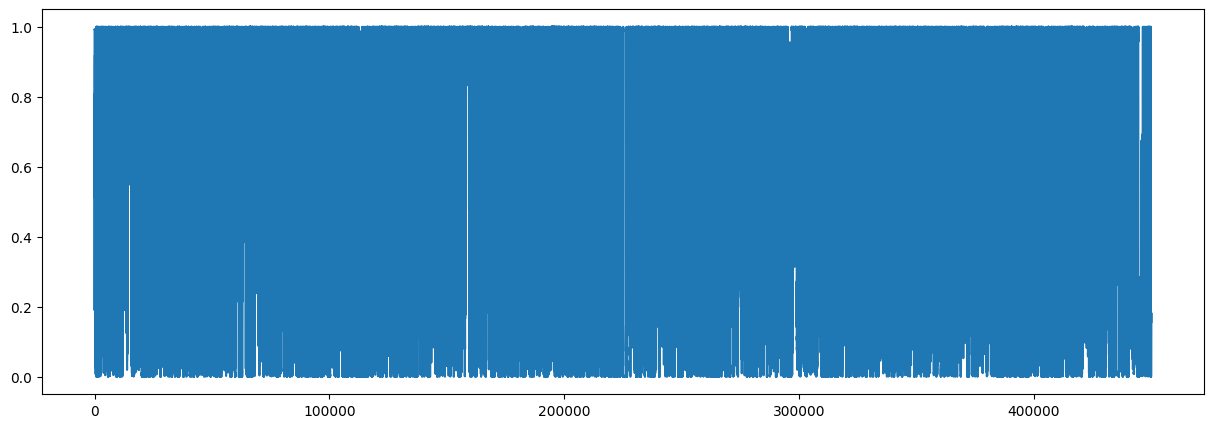

In [55]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(Y[0, ...])
plt.show()